In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import Statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Cleaning the Training Dataset

In [2]:
# Read the Dataset
tr = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
tr.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Shape of the Data
print('Shape: ', tr.shape, '\n')

# Check for the NaN or Missing data
null = tr.isna().sum()
print(null.head(10), '\n')

# Make a column list
cols = list(tr.columns)
print('Column List: ', cols[0:7], '\n')

# Identifying the cols which have NaNs
nan = []
nan_num = []
for i in range(len(null)):
    if null[i] > 0:
        nan.append(cols[i])
        nan_num.append(null[i])
print('NaN Columns: ', nan)
print('Number of NaNs in the column: ', nan_num)

# Calculating the NaN % in the columns
dicts = {nan[i]: round((nan_num[i]/len(tr))*100, 2) for i in range(len(nan))}
nan_percent = pd.Series(dicts)
print()
print('Column % DataFrame: ')
print(nan_percent)

Shape:  (1460, 81) 

Id                0
MSSubClass        0
MSZoning          0
LotFrontage     259
LotArea           0
Street            0
Alley          1369
LotShape          0
LandContour       0
Utilities         0
dtype: int64 

Column List:  ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley'] 

NaN Columns:  ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Number of NaNs in the column:  [259, 1369, 8, 8, 37, 37, 38, 37, 38, 1, 690, 81, 81, 81, 81, 81, 1453, 1179, 1406]

Column % DataFrame: 
LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType      

In [4]:
# Dropping the unnecessary columns
filtered_nan_cols = []
for i in range(len(nan)):
    if nan_percent[i] > 50:
        tr.drop(nan[i], axis=1, inplace=True)
    else:
        filtered_nan_cols.append(nan[i])
        
obj_ft = list(tr[filtered_nan_cols].select_dtypes(include='object'))
num_ft = list(tr[filtered_nan_cols].select_dtypes(exclude='object'))

tr.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [5]:
# Object % Numerical type columns
print('Object Features', obj_ft)
print('Numerical Features: ', num_ft)

Object Features ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Numerical Features:  ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


# Visualize Data

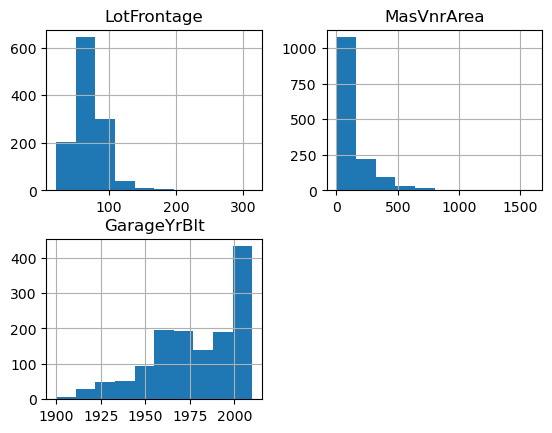

In [6]:
tr[num_ft].hist();

In [7]:
# Filling the missing data
tr['LotFrontage'].fillna(tr['LotFrontage'].mean(), inplace=True)
tr[num_ft[1]].fillna(tr[num_ft[1]].mode()[0], inplace=True)
tr[num_ft[2]].fillna(tr[num_ft[2]].mode()[0], inplace=True)

tr = tr.ffill().bfill()
tr[filtered_nan_cols].isna().sum()

LotFrontage     0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [8]:
# Cross-Check fot NaNs
new_cols = list(tr.columns)
string = ''
check = 0
for i in range(len(new_cols)):
    if tr.isna().sum()[i] > 0:
        print('Missing Values Found!')
    else:
        check+=1
print(check)

77


# Correlation()

In [9]:
# Finding correlation() between the features
corr = tr.corr()
salePrice = tr['SalePrice']

# After referring some Kaggle notebooks, Internet, and Blogs on correlation, 0.5 - 0.7 correlation value implies features are moderately correlated and >0.7 implies highly correlated
corr_ft = corr.index[abs(corr['SalePrice']) > 0.5]
corr_ft = corr_ft[0:len(corr_ft) - 1]
print(f'Highly correlated features:\n {corr_ft}\n')
print(f'No. of correlated features: {len(corr_ft)}')

Highly correlated features:
 Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea'],
      dtype='object')

No. of correlated features: 10


In [10]:
tr = pd.get_dummies(tr[corr_ft], drop_first=True)
tr.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
0,7,2003,2003,856,856,1710,2,8,2,548
1,6,1976,1976,1262,1262,1262,2,6,2,460
2,7,2001,2002,920,920,1786,2,6,2,608
3,7,1915,1970,756,961,1717,1,7,3,642
4,8,2000,2000,1145,1145,2198,2,9,3,836


In [11]:
tr.shape

(1460, 10)

# Test Dataset

In [12]:
tst = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
tst.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [13]:
# Shape of the Data
print('Shape: ', tst.shape, '\n')

# Check for the NaN or Missing data
null_tst = tst.isna().sum()
print(null_tst.head(10), '\n')

# Make a column list
tst_cols = list(tst.columns)
print('Column List: ', tst_cols[0:7], '\n')

# Identifying the cols which have NaNs
nan_tst = []
nan_num_tst = []
for i in range(len(null_tst)):
    if null[i] > 0:
        nan_tst.append(tst_cols[i])
        nan_num_tst.append(null_tst[i])
print('NaN Columns: ', nan_tst)
print('Number of NaNs in the column: ', nan_num_tst)

# Calculating the NaN % in the columns
dicts_tst = {nan_tst[i]: round((nan_num_tst[i]/len(tst))*100, 2) for i in range(len(nan_tst))}
nan_percent_tst = pd.Series(dicts_tst)
print()
print('Column % DataFrame: ')
print(nan_percent_tst)

Shape:  (1459, 80) 

Id                0
MSSubClass        0
MSZoning          4
LotFrontage     227
LotArea           0
Street            0
Alley          1352
LotShape          0
LandContour       0
Utilities         2
dtype: int64 

Column List:  ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley'] 

NaN Columns:  ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Number of NaNs in the column:  [227, 1352, 16, 15, 44, 45, 44, 42, 42, 0, 730, 76, 78, 78, 78, 78, 1456, 1169, 1408]

Column % DataFrame: 
LotFrontage     15.56
Alley           92.67
MasVnrType       1.10
MasVnrArea       1.03
BsmtQual         3.02
BsmtCond         3.08
BsmtExposure     3.02
BsmtFinType1     2.88
BsmtFinType2     2.88
Electrical       0.00
FireplaceQu     50.03
GarageType    

In [14]:
# Dropping the unnecessary columns
filtered_tst_cols = []
for i in range(len(nan_tst)):
    if nan_percent_tst[i] > 50:
        tst.drop(nan_tst[i], axis=1, inplace=True)
    else:
        filtered_tst_cols.append(nan_tst[i])
        
object_ft = list(tst[filtered_tst_cols].select_dtypes(include='object'))
int_ft = list(tst[filtered_tst_cols].select_dtypes(exclude='object'))

tst.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal


In [15]:
# Object % Numerical type columns
print('Object Features', object_ft)
print('Numerical Features: ', int_ft)

Object Features ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Numerical Features:  ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


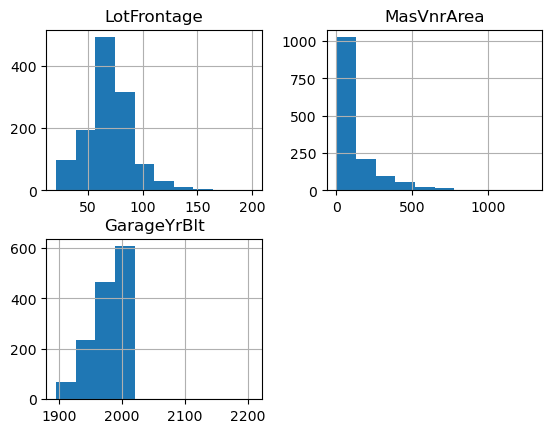

In [16]:
tst[int_ft].hist();

In [17]:
# Filling the missing data
tst[int_ft[0]].fillna(tst[int_ft[0]].mean(), inplace=True)
tst[int_ft[1]].fillna(tst[int_ft[1]].mode()[0], inplace=True)
tst[int_ft[2]].fillna(tst[int_ft[2]].mode()[0], inplace=True)

tst = tst.ffill().bfill()
tst[filtered_tst_cols].isna().sum()

LotFrontage     0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [18]:
# Cross-Check fot NaNs
new_tst_cols = list(tst.columns)
string = ''
check = 0
for i in range(len(new_tst_cols)):
    if tst.isna().sum()[i] > 0:
        print('Missing Values Found!')
    else:
        check+=1
print(check)

75


# Correlation()

In [19]:
tst = pd.get_dummies(tst[corr_ft], drop_first=True)
tst.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
0,5,1961,1961,882.0,896,896,1,5,1.0,730.0
1,6,1958,1958,1329.0,1329,1329,1,6,1.0,312.0
2,5,1997,1998,928.0,928,1629,2,6,2.0,482.0
3,6,1998,1998,926.0,926,1604,2,7,2.0,470.0
4,8,1992,1992,1280.0,1280,1280,2,5,2.0,506.0


In [20]:
tst.shape

(1459, 10)

# Sample Submission

In [21]:
sample = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [22]:
# Split the data
np.random.seed(2)
x = tr
y = salePrice

x_tr, x_tst, y_tr, y_tst = train_test_split(x, y, test_size=0.1, random_state=5)
x_tr.shape, x_tst.shape, y_tr.shape, y_tst.shape

((1314, 10), (146, 10), (1314,), (146,))

# Build a ML Model

> RandomForestRegressor

> RandomizedSearchCV

> GridSearchCV

> TransformedTargetRegressor

### RandomForestRegressor()

In [23]:
# Instantiate RandomForestRegressor()
np.random.seed(2)
rfr = RandomForestRegressor()
# Fit the model
rfr.fit(x_tr, y_tr)

RandomForestRegressor()

In [24]:
# Evaluate the Model
mse = mean_squared_error
def evaluate(model):
    metrics = {
        'Train Accuracy': model.score(x_tr, y_tr),
        'Test Accuracy': model.score(x_tst, y_tst),
        'R2 Score': r2_score(np.array(y_tst), rfr.predict(x_tst)),
        'RMSE': np.sqrt(mse(np.log(np.array(y_tst)), np.log(rfr.predict(x_tst))))
    }
    return metrics
    
evaluate(rfr)

{'Train Accuracy': 0.9748991647328145,
 'Test Accuracy': 0.8934621284516221,
 'R2 Score': 0.8934621284516221,
 'RMSE': 0.16511883175291786}

In [25]:
np.sqrt(mse(np.log(np.array(sample['SalePrice'])), np.log(rfr.predict(tst))))

0.3643846768719009

### RandomizedSearchCV

In [26]:
grid = {
    'bootstrap': [True, False],
    'max_depth': [20, 40, 60, 80, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'criterion' : ['squared_error'],
    'min_samples_split': [2, 5, 10],
    'n_estimators': np.arange(100, 1500, 100, dtype=int)
}

# Instantiate RandomizedSearchCV
np.random.seed(2)
rsv = RandomizedSearchCV(RandomForestRegressor(), grid, n_iter=10, random_state=2)
rsv.fit(x_tr, y_tr)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error'],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400])},
                   random_state=2)

In [27]:
evaluate(rsv)

{'Train Accuracy': 0.947652523173832,
 'Test Accuracy': 0.8680376898725075,
 'R2 Score': 0.8934621284516221,
 'RMSE': 0.16511883175291786}

In [28]:
rsv.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'squared_error',
 'bootstrap': True}

In [29]:
r2_score(np.array(sample['SalePrice']), rsv.predict(tst)), np.sqrt(mse(np.log(np.array(sample['SalePrice'])), np.log(rsv.predict(tst))))

(-16.009080109742033, 0.3509161713434297)

### GridSearchCV()

In [30]:
grid_search = {'n_estimators': [800, 1000, 1200],
 'min_samples_split': [2],
 'min_samples_leaf': [1, 2],
 'max_features': ['sqrt'],
 'max_depth': [100],
 'criterion': ['squared_error'],
 'bootstrap': [True, False]}

# Instantiate GridSearchCV
np.random.seed(2)
gsv = GridSearchCV(RandomForestRegressor(), grid_search)
gsv.fit(x_tr, y_tr)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['squared_error'], 'max_depth': [100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2],
                         'n_estimators': [800, 1000, 1200]})

In [31]:
gsv.best_params_

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 800}

In [32]:
np.sqrt(mse(np.log(np.array(sample['SalePrice'])), np.log(gsv.predict(tst))))

0.35048218321682373

### TransformedTargetRegressor()

In [33]:
# Instantiate TransformedTargetRegressor()
# {'n_estimators': 1400,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 40,
#  'criterion': 'squared_error',
#  'bootstrap': True}

In [34]:
for i in np.linspace(0.001, 0.01, 10):
    np.random.seed(2)
    gbr = GradientBoostingRegressor(n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_depth=100, loss='squared_error', learning_rate=i, max_features='sqrt')
    gbr.fit(x_tr, y_tr)
    print('LR: ', i)
    print(gbr.score(x_tr, y_tr), gbr.score(x_tst, y_tst), r2_score(y_tst, gbr.predict(x_tst)), np.sqrt(mse(np.log(y_tst), np.log(gbr.predict(x_tst)))))
    print(np.sqrt(mse(np.log(sample['SalePrice']), np.log(gbr.predict(tst)))))

LR:  0.001
0.8935134689514859 0.7969130610610291 0.7969130610610291 0.22218697562713075
0.24706328008139875
LR:  0.002
0.9864587039817762 0.8964503808493979 0.8964503808493979 0.17890276117128162
0.32700886638749616
LR:  0.003
0.9976215181522394 0.911643470958206 0.911643470958206 0.17152515176817262
0.35394784772657556
LR:  0.004
0.9993454095176084 0.9148901475958688 0.9148901475958688 0.17022115402131768
0.3624493051188031
LR:  0.005
0.9997075882652936 0.9162207520328901 0.9162207520328901 0.1688937169969098
0.36534156706293197
LR:  0.006
0.9998109215649109 0.9163812202569763 0.9163812202569763 0.16906044023707273
0.3666285741732968
LR:  0.007
0.9998518794435133 0.9148176116240798 0.9148176116240798 0.16949753172494872
0.3657971792479171
LR:  0.008
0.9998658753609249 0.9189175908272933 0.9189175908272933 0.16788235386844147
0.3672139845896942
LR:  0.009000000000000001
0.9998711071626776 0.9164477204562532 0.9164477204562532 0.16864994418146195
0.3668079199004104
LR:  0.01
0.999872761

In [35]:
preds = pd.Series(gbr.predict(tst))
submission = sample.drop('SalePrice', axis=1)
submission['SalePrice'] = preds
submission.to_csv('submission.csv', index=False)
submission

,Id,SalePrice
0,1461,119154.146401
1,1462,149199.368480
2,1463,171278.503493
3,1464,181084.982726
4,1465,217557.467325
...,...,...
1454,2915,82957.322147
1455,2916,81498.622471
1456,2917,145599.223973
1457,2918,104428.975000


In [36]:
final_sub = pd.read_csv('/kaggle/working/submission.csv')
final_sub
# # Get a list of all column names in the dataframe
# ft = list(df.columns)

# # Create a LabelEncoder object
# label = LabelEncoder()

# # Apply LabelEncoder to all columns in the dataframe
# for col in ft:
#     if df[col].dtype == object:
#         df[col] = label.fit_transform(df[col].astype(str))

# # Create a OneHotEncoder object with sparse output
# encoder = OneHotEncoder(sparse=True)

# # Apply OneHotEncoder to the encoded dataframe
# ohe = encoder.fit_transform(df)

# # Convert the one-hot-encoded output to a dense numpy array and create a new dataframe
# df_obj = pd.DataFrame(ohe.toarray(), index=df.index)

# # Extract all columns that were not one-hot-encoded
# df_num = df.drop(columns=ft)

# # Concatenate the one-hot-encoded and numerical dataframes
# df = pd.concat([df_obj, df_num], axis=1)

,Id,SalePrice
0,1461,119154.146401
1,1462,149199.368480
2,1463,171278.503493
3,1464,181084.982726
4,1465,217557.467325
...,...,...
1454,2915,82957.322147
1455,2916,81498.622471
1456,2917,145599.223973
1457,2918,104428.975000


In [37]:
# # Finding correlation() between the features
# corr = df.corr()

# # After referring some Kaggle notebooks, Internet, and Blogs on correlation, 0.5 - 0.7 correlation value implies features are moderately correlated and >0.7 implies highly correlated
# high_corr_ft = corr.index[abs(corr['SalePrice']) >= 0.30]
# print(f'Highly correlated features:\n {high_corr_ft}\n')
# print(f'No. of correlated features: {len(high_corr_ft)}')